__Dataset__:
- Bridge Classification
- Data source: UCI

__Project Goal__: Experiment various methods of imputation for missing data.

__Methods Used__:
Imputation Methods: 
1. [Row Deletion](#rows)
2. [Statistical imputation](#stat)
3. [Predictive imputation](#predictive)
    1. Regression
    2. KNN Imputation
    3. Bayesian Ridge imputer
    4. Decision Trees imputer
    5. [Results](#results)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [2]:
#Loading the dataset and headers

headers = ['ID','River','Location','Erected','Purpose','Length','Lanes','Clear-g','T or D','Material','Span','Rel-l','Type']
data_1 = pd.read_csv(r'',header= 0,names=headers,index_col=0)

In [3]:
data_1.sort_index().head()

,River,Location,Erected,Purpose,Length,Lanes,Clear-g,T or D,Material,Span,Rel-l,Type
ID,,,,,,,,,,,,
E1,M,3,1818,HIGHWAY,?,2,N,THROUGH,WOOD,SHORT,S,WOOD
E10,A,39,1848,AQUEDUCT,?,1,N,DECK,WOOD,?,S,WOOD
E100,O,43,1982,HIGHWAY,?,?,G,?,?,?,F,?
E101,O,46,1927,HIGHWAY,1770,2,G,THROUGH,STEEL,LONG,S-F,CANTILEV
E102,O,47,1959,HIGHWAY,1700,2,G,THROUGH,STEEL,LONG,F,CONT-T


In [4]:
data_1.shape

(108, 12)

In [5]:
#Frequency of our target variable
data_1.iloc[:,-1].value_counts()

SIMPLE-T    44
WOOD        16
ARCH        12
CANTILEV    11
SUSPEN      11
CONT-T      10
?            2
ARCH-T       1
NIL          1
Name: Type, dtype: int64

### 1. Dealing with missing values
There are many rows with missing values which are shown as '?'.

1.1 Check which rows have ? and count the number of columns in each row having '?'




In [6]:
#Function to plot tables side by side
from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell'''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [7]:
j = pd.DataFrame((data_1.isin(['?']).sum(axis=1)).value_counts().sort_values(),columns=['Rows Count'])
j.index.name='# missing values'
k = pd.DataFrame((data_1.isin(['?']).sum(axis=0)),columns=['Number of missing values'])
k.index.name='Column names'

In [8]:
multi_table([j,k])

,Rows Count
# missing values,
6,2
3,2
4,4
2,13
1,17
0,70
,Number of missing values
Column names,
River,0


### 1.2 Methods
1- Delete rows or

2- Impute with test statistic or

3- Conduct predictive analytics

<a id="rows"></a>
### 1.2.1 We will remove the rows which have more than 1 missing 

In [9]:
data_cleaned_1=data_1[(data_1.isin(['?']).sum(axis=1)<2)].copy()

In [10]:
print ('Shape',data_cleaned_1.shape)
print ('This means we deleted',round((data_1.shape[0]-data_cleaned_1.shape[0])*100/data_1.shape[0],2),'% of data')

Shape (87, 12)
This means we deleted 19.44 % of data


#### Probably not the best option, since we lose close to 20% of our dataset. Instead of removing all the rows with more than 1 missing attribute, we can just remove the rows having more than 4 attributes. In that case, we would just be removing 6 rows,i.e., 5.5% of data instead of 20%.

In [11]:
k_1=pd.DataFrame(data_cleaned_1.isin(['?']).sum(axis=0),columns=['after cleaning'])
k_1.index.name='Column names'
j_1=pd.DataFrame(data_cleaned_1.isin(['?']).sum(axis=1).value_counts().sort_values(),columns=[' after cleaning'])
j_1.index.name='# missing values'

In [12]:
multi_table([j,j_1,k,k_1])

,Rows Count
# missing values,
6,2
3,2
4,4
2,13
1,17
0,70
,after cleaning
# missing values,
1,17


In [13]:
print (' We deleted', data_1.shape[0]-data_cleaned_1.shape[0],'rows')

 We deleted 21 rows


### We will now impute the missing values in following columns:

1. Length 
2. Lanes
3. Span
4. Rei-i
5. Clear-g

Since Length is missing in 20 rows and is a continuous variable, I will impute it using method 3, i.e predictive algorithm.

Other all the missing variables, I'll do it by test statistic.

In [14]:
#Replacing ? with NaN
data_cleaned_1= data_cleaned_1.replace(r'\?',np.nan,regex=True).copy()

In [15]:
data_cleaned_1.head()

Column names,River,Location,Erected,Purpose,Length,Lanes,Clear-g,T or D,Material,Span,Rel-l,Type
ID,,,,,,,,,,,,
E1,M,3,1818,HIGHWAY,NaN,2,N,THROUGH,WOOD,SHORT,S,WOOD
E30,A,31,1884,RR,NaN,2,G,THROUGH,STEEL,MEDIUM,F,SIMPLE-T
E32,A,30,1887,HIGHWAY,NaN,2,G,THROUGH,IRON,MEDIUM,F,SIMPLE-T
E36,O,45,1890,HIGHWAY,NaN,2,G,THROUGH,IRON,SHORT,F,SIMPLE-T
E38,M,17,1891,HIGHWAY,NaN,2,G,THROUGH,IRON,MEDIUM,F,SIMPLE-T


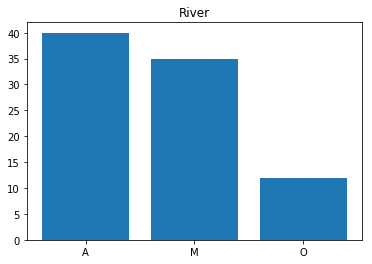

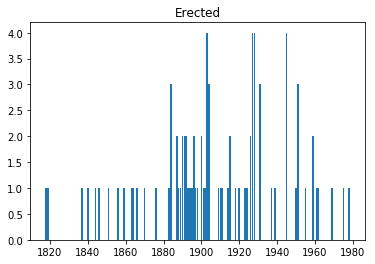

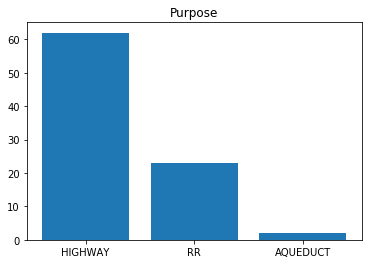

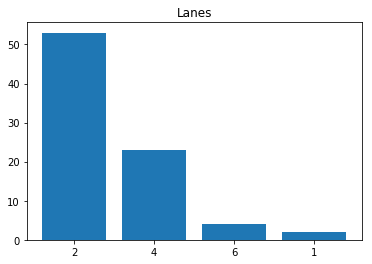

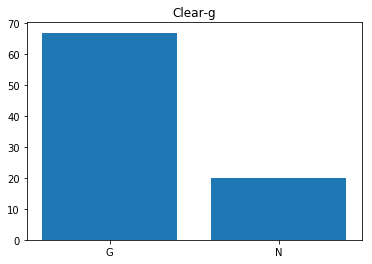

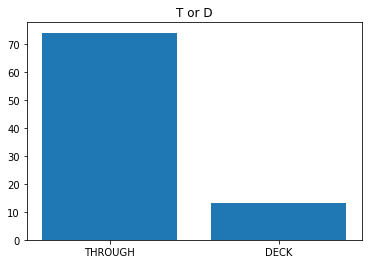

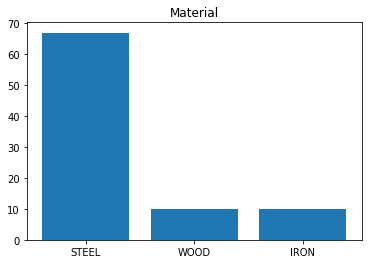

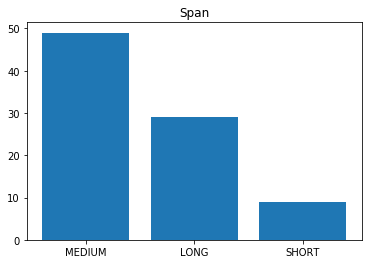

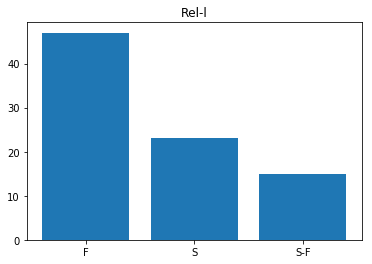

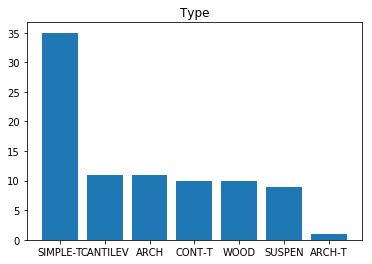

In [16]:
#Plot frequency table for all columns
for i in [0,2,3,5,6,7,8,9,10,11]:
        plt.bar(data_cleaned_1.iloc[:,i].value_counts().index,data_cleaned_1.iloc[:,i].value_counts())
        plt.title(data_cleaned_1.columns[i])
        plt.show()



In [17]:
data_cleaned_1.Lanes=pd.to_numeric(data_cleaned_1.Lanes)

data_cleaned_1.Length=pd.to_numeric(data_cleaned_1.Length)

<a id="stat"></a>
### 1.2.2 Using test statistics to impute. 


In [18]:
data_cleaned_2 = data_cleaned_1[data_cleaned_1.isna().sum(axis=1)<2].copy()

In [19]:
data_cleaned_2.shape

(87, 12)

In [20]:
data_cleaned_2.columns[data_cleaned_2.isna().sum(axis=0)>0]

Index(['Length', 'Lanes', 'Rel-l'], dtype='object', name='Column names')

We observe that a few variables such as Lanes and Clear-G are no more missing. This is because when we deleted rows with NaN>2,they were included in that.
 
Following columns are imputed with this method:
1. Lanes
2. Rei-I

In [21]:
print(data_cleaned_2[data_cleaned_2.isna().sum(axis=1)>0].shape[0],'rows to be imputed')

17 rows to be imputed


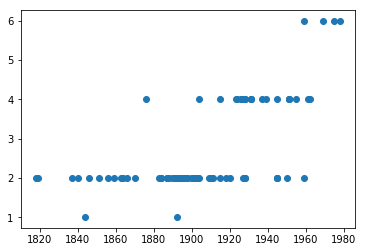

In [22]:
#Trend of Lanes with respect to year the bridge was erected
plt.scatter(data_cleaned_2.Erected,data_cleaned_2.Lanes)
plt.show()

In [23]:
#Grouping the bridges to get the number of lanes. I have used the mode as the test statistic to identify the lane of a bridge
data_cleaned_2.groupby([data_cleaned_2.columns[-5],data_cleaned_2.Material,data_cleaned_2.Span,data_cleaned_2.Type,data_cleaned_2.Purpose,data_cleaned_2.Lanes]).size()

T or D   Material  Span    Type      Purpose   Lanes
DECK     STEEL     LONG    CONT-T    HIGHWAY   4.0       4
                                     RR        2.0       1
                           SIMPLE-T  RR        2.0       1
                   MEDIUM  ARCH      HIGHWAY   4.0       1
                           CANTILEV  HIGHWAY   2.0       1
                                               4.0       2
                           CONT-T    HIGHWAY   2.0       1
                                               4.0       2
THROUGH  IRON      MEDIUM  SIMPLE-T  HIGHWAY   2.0       3
                                     RR        2.0       1
                           SUSPEN    HIGHWAY   2.0       1
                   SHORT   SIMPLE-T  HIGHWAY   2.0       1
                                     RR        2.0       1
                           SUSPEN    AQUEDUCT  1.0       1
                                     HIGHWAY   2.0       1
         STEEL     LONG    ARCH      HIGHWAY   2.0       1
   

In [24]:
data_cleaned_2.groupby([data_cleaned_2.columns[-5],data_cleaned_2.Material,data_cleaned_2.Span,data_cleaned_2.Type,data_cleaned_2.Purpose,data_cleaned_2.columns[-2]]).size()

T or D   Material  Span    Type      Purpose   Rel-l
DECK     STEEL     LONG    CONT-T    HIGHWAY   F        3
                                               S-F      1
                                     RR        F        1
                           SIMPLE-T  RR        F        1
                   MEDIUM  ARCH      HIGHWAY   F        1
                           CANTILEV  HIGHWAY   F        1
                                               S-F      2
                           CONT-T    HIGHWAY   S-F      3
THROUGH  IRON      MEDIUM  SIMPLE-T  HIGHWAY   F        4
                           SUSPEN    HIGHWAY   S-F      1
                   SHORT   SIMPLE-T  HIGHWAY   F        1
                                     RR        S        1
                           SUSPEN    AQUEDUCT  S        1
                                     HIGHWAY   S        1
         STEEL     LONG    ARCH      HIGHWAY   F        6
                           CANTILEV  HIGHWAY   F        4
                   

In [25]:
data_cleaned_2[data_cleaned_2.Lanes.isna()]

Column names,River,Location,Erected,Purpose,Length,Lanes,Clear-g,T or D,Material,Span,Rel-l,Type
ID,,,,,,,,,,,,
E92,M,10,1914,RR,2210.0,NaN,G,THROUGH,STEEL,MEDIUM,F,SIMPLE-T
E73,A,38,1927,HIGHWAY,1508.0,NaN,G,THROUGH,STEEL,MEDIUM,S,ARCH
E52,M,2,1904,RR,1504.0,NaN,G,THROUGH,STEEL,LONG,F,CANTILEV
E50,M,21,1903,RR,1154.0,NaN,G,THROUGH,STEEL,LONG,F,SIMPLE-T
E33,M,19,1889,HIGHWAY,1120.0,NaN,G,THROUGH,IRON,MEDIUM,F,SIMPLE-T


In [26]:
data_cleaned_2.loc['E92','Lanes'] = 2
data_cleaned_2.loc['E73','Lanes'] = 4
data_cleaned_2.loc['E52','Lanes'] = 2
data_cleaned_2.loc['E50','Lanes'] = 2
data_cleaned_2.loc['E33','Lanes'] = 2

In [27]:
#Check for any missing values
data_cleaned_2[data_cleaned_2.Lanes.isna()]

Column names,River,Location,Erected,Purpose,Length,Lanes,Clear-g,T or D,Material,Span,Rel-l,Type
ID,,,,,,,,,,,,


In [28]:
data_cleaned_2.loc['E17','Rel-l']='F'
data_cleaned_2.loc['E29','Rel-l']='S-F'

In [29]:
data_cleaned_2[data_cleaned_2.isnull().sum(axis=1)>0]

Column names,River,Location,Erected,Purpose,Length,Lanes,Clear-g,T or D,Material,Span,Rel-l,Type
ID,,,,,,,,,,,,
E1,M,3,1818,HIGHWAY,NaN,2.0,N,THROUGH,WOOD,SHORT,S,WOOD
E30,A,31,1884,RR,NaN,2.0,G,THROUGH,STEEL,MEDIUM,F,SIMPLE-T
E32,A,30,1887,HIGHWAY,NaN,2.0,G,THROUGH,IRON,MEDIUM,F,SIMPLE-T
E36,O,45,1890,HIGHWAY,NaN,2.0,G,THROUGH,IRON,SHORT,F,SIMPLE-T
E38,M,17,1891,HIGHWAY,NaN,2.0,G,THROUGH,IRON,MEDIUM,F,SIMPLE-T
E39,A,25,1892,HIGHWAY,NaN,2.0,G,THROUGH,STEEL,MEDIUM,F,SIMPLE-T
E40,M,22,1893,HIGHWAY,NaN,2.0,G,THROUGH,STEEL,MEDIUM,F,SIMPLE-T
E41,M,11,1894,HIGHWAY,NaN,2.0,G,THROUGH,IRON,MEDIUM,F,SIMPLE-T
E44,O,48,1896,HIGHWAY,NaN,2.0,G,THROUGH,STEEL,LONG,F,SUSPEN


Only length is missing 

<a id="predictive"></a>
### 1.2.3 Using algorithm to impute the missing values

The idea now is to impute the length using a machine learning algorithm. <br>
I will be trying the following approaches:

1. Regression

2. KNN Imputation

3. Predictive Mean Matching (PMM) :- a somewhat combination of Regression and KNN

4. Decision Trees

In [30]:
multi_table([pd.DataFrame(data_cleaned_2.isna().sum()),pd.DataFrame(data_cleaned_2.dtypes)])

,0
Column names,
River,0
Location,0
Erected,0
Purpose,0
Length,10
Lanes,0
Clear-g,0
T or D,0
Material,0


In [31]:
data_cleaned_2.Erected = data_cleaned_2.Erected.astype(object)

In [32]:
categorical_feature_mask = data_cleaned_2.dtypes==object

In [33]:
category_columns = data_cleaned_2.columns[categorical_feature_mask].tolist()

In [34]:
print(category_columns)

['River', 'Location', 'Erected', 'Purpose', 'Clear-g', 'T or D', 'Material', 'Span', 'Rel-l', 'Type']


In [35]:
data_3_dummy = pd.get_dummies(data_cleaned_2,drop_first=True)

In [36]:
data_3_dummy.head(2)

,Length,Lanes,River_M,River_O,Location_10,Location_11,Location_12,Location_13,Location_14,Location_15,...,Span_MEDIUM,Span_SHORT,Rel-l_S,Rel-l_S-F,Type_ARCH-T,Type_CANTILEV,Type_CONT-T,Type_SIMPLE-T,Type_SUSPEN,Type_WOOD
ID,,,,,,,,,,,,,,,,,,,,,
E1,NaN,2.0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1
E30,NaN,2.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [37]:
data_3_dummy.shape

(87, 127)

#### Dataframe split for prediction

In [38]:
#Test Set
missing_length_features = data_3_dummy[data_3_dummy.Length.isnull()].iloc[:,1:].copy() 

In [39]:
missing_length_features.head(1)

,Lanes,River_M,River_O,Location_10,Location_11,Location_12,Location_13,Location_14,Location_15,Location_16,...,Span_MEDIUM,Span_SHORT,Rel-l_S,Rel-l_S-F,Type_ARCH-T,Type_CANTILEV,Type_CONT-T,Type_SIMPLE-T,Type_SUSPEN,Type_WOOD
ID,,,,,,,,,,,,,,,,,,,,,
E1,2.0,1,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1


In [40]:
missing_length_features.shape

(10, 126)

In [41]:
#Training Set

length_data = data_3_dummy[data_3_dummy.Length.notnull()].copy()

#Features of data having known Length
length_training = data_3_dummy[data_3_dummy.Length.notnull()].iloc[:,1:].copy()

#Target variable of data having known length
length_train_target = data_3_dummy[data_3_dummy.Length.notnull()].iloc[:,0].copy()

In [42]:
print(length_train_target.shape)
length_train_target.head(1)

(77,)


ID
E34    4558.0
Name: Length, dtype: float64

In [43]:
print(length_training.shape)
length_training.head(1)

(77, 126)


,Lanes,River_M,River_O,Location_10,Location_11,Location_12,Location_13,Location_14,Location_15,Location_16,...,Span_MEDIUM,Span_SHORT,Rel-l_S,Rel-l_S-F,Type_ARCH-T,Type_CANTILEV,Type_CONT-T,Type_SIMPLE-T,Type_SUSPEN,Type_WOOD
ID,,,,,,,,,,,,,,,,,,,,,
E34,2.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### 1.2.3.1 Predicting Length using Linear regression for imputation.

In [44]:
from sklearn import linear_model

In [45]:
missing_data_regr = linear_model.LinearRegression() 

In [46]:
missing_data_regr.fit(length_training,length_train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
final_rgr_table = missing_length_features.copy()

In [48]:
final_rgr_table['Length'] = np.round(missing_data_regr.predict(missing_length_features),0)

In [49]:
final_rgr_table

,Lanes,River_M,River_O,Location_10,Location_11,Location_12,Location_13,Location_14,Location_15,Location_16,...,Span_SHORT,Rel-l_S,Rel-l_S-F,Type_ARCH-T,Type_CANTILEV,Type_CONT-T,Type_SIMPLE-T,Type_SUSPEN,Type_WOOD,Length
ID,,,,,,,,,,,,,,,,,,,,,
E1,2.0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,1050.0
E30,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1856.0
E32,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1624.0
E36,2.0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1738.0
E38,2.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1628.0
E39,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1379.0
E40,2.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1682.0
E41,2.0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1390.0
E44,2.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2431.0


In [50]:
cols = final_rgr_table.columns.tolist()
cols = cols[-1:] + cols[:-1]
final_rgr_table = final_rgr_table[cols]

In [51]:
result_reg = pd.concat([final_rgr_table,length_data],keys = ['predicted','original'],sort=False)

In [52]:
result_reg.head(13)

Length  Lanes  River_M  River_O  Location_10  Location_11  \
          ID                                                               
predicted E1   1050.0    2.0        1        0            0            0   
          E30  1856.0    2.0        0        0            0            0   
          E32  1624.0    2.0        0        0            0            0   
          E36  1738.0    2.0        0        1            0            0   
          E38  1628.0    2.0        1        0            0            0   
          E39  1379.0    2.0        0        0            0            0   
          E40  1682.0    2.0        1        0            0            0   
          E41  1390.0    2.0        1        0            0            1   
          E44  2431.0    2.0        0        1            0            0   
          E94  1799.0    2.0        1        0            0            0   
original  E34  4558.0    2.0        0        1            0            0   
          E46  4000.0    2.0        0        0            0            0   
          E91  3756.0    6.0        0        1            0            0   

               Location_12  Location_13  Location_14  Location_15  ...  \
          ID                                                       ...   
predicted E1             0            0            0            0  ...   
          E30            0            0            0            0  ...   
          E32            0            0            0            0  ...   
          E36            0            0            0            0  ...   
          E38            0            0            0            0  ...   
          E39            0            0            0            0  ...   
          E40            0            0            0            0  ...   
          E41            0            0            0            0  ...   
          E44            0            0            0            0  ...   
          E94            0            1            0            0  ...   
original  E34            0            0            0            0  ...   
          E46            0            0            0            0  ...   
          E91            0            0            0            0  ...   

               Span_MEDIUM  Span_SHORT  Rel-l_S  Rel-l_S-F  Type_ARCH-T  \
          ID                                                              
predicted E1             0           1        1          0            0   
          E30            1           0        0          0            0   
          E32            1           0        0          0            0   
          E36            0           1        0          0            0   
          E38            1           0        0          0            0   
          E39            1           0        0          0            0   
          E40            1           0        0          0            0   
          E41            1           0        0          0            0   
          E44            0           0        0          0            0   
          E94            0           0        0          0            0   
original  E34            0           0        0          0            0   
          E46            0           0        0          0            0   
          E91            0           0        0          0            0   

               Type_CANTILEV  Type_CONT-T  Type_SIMPLE-T  Type_SUSPEN  \
          ID                                                            
predicted E1               0            0              0            0   
          E30              0            0              1            0   
          E32              0            0              1            0   
          E36              0            0              1            0   
          E38              0            0              1            0   
          E39              0            0              1            0   
          E40              0            0            

#### 1.2.3.2 Predicting Length using KNN for imputation.

In [53]:
from sklearn.neighbors import KNeighborsRegressor

In [54]:
missing_data_knn = KNeighborsRegressor()

In [55]:
missing_model_knn = missing_data_knn.fit(length_training,length_train_target)

In [56]:
predicted_length_data_knn = missing_model_knn.predict(missing_length_features)

In [57]:
predicted_length_data_knn

array([1145.4, 1917.8, 1410. , 2015.8, 1817.4, 1659.4, 1787.4, 1747.4,
       1664.4, 1994. ])

In [58]:
final_knn_table = missing_length_features.copy()

In [59]:
final_knn_table['Length'] = np.round(predicted_length_data_knn,0)

In [60]:
final_knn_table = final_knn_table[cols]
final_knn_table

,Length,Lanes,River_M,River_O,Location_10,Location_11,Location_12,Location_13,Location_14,Location_15,...,Span_MEDIUM,Span_SHORT,Rel-l_S,Rel-l_S-F,Type_ARCH-T,Type_CANTILEV,Type_CONT-T,Type_SIMPLE-T,Type_SUSPEN,Type_WOOD
ID,,,,,,,,,,,,,,,,,,,,,
E1,1145.0,2.0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1
E30,1918.0,2.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
E32,1410.0,2.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
E36,2016.0,2.0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
E38,1817.0,2.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
E39,1659.0,2.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
E40,1787.0,2.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
E41,1747.0,2.0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
E44,1664.0,2.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [61]:
#Concate
result_knn = pd.concat([final_knn_table,length_data],keys=['Predicted','Original'],sort = False)

In [62]:
result_knn.head(15)

Length  Lanes  River_M  River_O  Location_10  Location_11  \
          ID                                                               
Predicted E1   1145.0    2.0        1        0            0            0   
          E30  1918.0    2.0        0        0            0            0   
          E32  1410.0    2.0        0        0            0            0   
          E36  2016.0    2.0        0        1            0            0   
          E38  1817.0    2.0        1        0            0            0   
          E39  1659.0    2.0        0        0            0            0   
          E40  1787.0    2.0        1        0            0            0   
          E41  1747.0    2.0        1        0            0            1   
          E44  1664.0    2.0        0        1            0            0   
          E94  1994.0    2.0        1        0            0            0   
Original  E34  4558.0    2.0        0        1            0            0   
          E46  4000.0    2.0        0        0            0            0   
          E91  3756.0    6.0        0        1            0            0   
          E87  3000.0    2.0        0        0            0            0   
          E61  2822.0    2.0        0        1            0            0   

               Location_12  Location_13  Location_14  Location_15  ...  \
          ID                                                       ...   
Predicted E1             0            0            0            0  ...   
          E30            0            0            0            0  ...   
          E32            0            0            0            0  ...   
          E36            0            0            0            0  ...   
          E38            0            0            0            0  ...   
          E39            0            0            0            0  ...   
          E40            0            0            0            0  ...   
          E41            0            0            0            0  ...   
          E44            0            0            0            0  ...   
          E94            0            1            0            0  ...   
Original  E34            0            0            0            0  ...   
          E46            0            0            0            0  ...   
          E91            0            0            0            0  ...   
          E87            0            0            0            0  ...   
          E61            0            0            0            0  ...   

               Span_MEDIUM  Span_SHORT  Rel-l_S  Rel-l_S-F  Type_ARCH-T  \
          ID                                                              
Predicted E1             0           1        1          0            0   
          E30            1           0        0          0            0   
          E32            1           0        0          0            0   
          E36            0           1        0          0            0   
          E38            1           0        0          0            0   
          E39            1           0        0          0            0   
          E40            1           0        0          0            0   
          E41            1           0        0          0            0   
          E44            0           0        0          0            0   
          E94            0           0        0          0            0   
Original  E34            0           0        0          0            0   
          E46            0           0        0          0            0   
          E91            0           0        0          0            0   
          E87            1           0        1          0            0   
          E61            0           0        0          0            0   

               Type_CANTILEV  Type_CONT-T  Type_SIMPLE-T  Type_SUSPEN  \
          ID                                                            
Predicted E1               0            0

In [63]:
pd.DataFrame([final_knn_table['Length'],final_rgr_table['Length']],index=['KNN imputation','Regression imputation']).T

,KNN imputation,Regression imputation
ID,,
E1,1145.0,1050.0
E30,1918.0,1856.0
E32,1410.0,1624.0
E36,2016.0,1738.0
E38,1817.0,1628.0
E39,1659.0,1379.0
E40,1787.0,1682.0
E41,1747.0,1390.0
E44,1664.0,2431.0


#### 1.2.3.3 Predicting Length using scikit-learn Impute for imputation.

1- Iterative Imputer & Bayesian Ridge

2- Iterative Imputer & Decision Trees

In [64]:
# now you can import normally from sklearn.impute
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor

In [65]:
imputer_br = IterativeImputer(estimator=BayesianRidge())

In [66]:
imputer_br.fit(data_3_dummy)

IterativeImputer(add_indicator=False,
                 estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                         compute_score=False, copy_X=True,
                                         fit_intercept=True, lambda_1=1e-06,
                                         lambda_2=1e-06, n_iter=300,
                                         normalize=False, tol=0.001,
                                         verbose=False),
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=None, random_state=None,
                 sample_posterior=False, tol=0.001, verbose=0)

In [77]:
missing_length_features.columns

Index(['Lanes', 'River_M', 'River_O', 'Location_10', 'Location_11',
       'Location_12', 'Location_13', 'Location_14', 'Location_15',
       'Location_16',
       ...
       'Span_MEDIUM', 'Span_SHORT', 'Rel-l_S', 'Rel-l_S-F', 'Type_ARCH-T',
       'Type_CANTILEV', 'Type_CONT-T', 'Type_SIMPLE-T', 'Type_SUSPEN',
       'Type_WOOD'],
      dtype='object', length=126)

In [67]:
imputer_data_br = missing_length_features.copy()

In [68]:
imputer_data_br['Length']=np.nan

In [78]:
imputer_data_br = imputer_data_br[cols]
imputer_data_br.index

Index(['E1', 'E30', 'E32', 'E36', 'E38', 'E39', 'E40', 'E41', 'E44', 'E94'], dtype='object', name='ID')

In [79]:
missing_data_iterative_br=pd.DataFrame(np.round(imputer_br.transform(imputer_data_br),0),columns=cols,index=imputer_data_br.index)

In [80]:
missing_data_iterative_br

,Length,Lanes,River_M,River_O,Location_10,Location_11,Location_12,Location_13,Location_14,Location_15,...,Span_MEDIUM,Span_SHORT,Rel-l_S,Rel-l_S-F,Type_ARCH-T,Type_CANTILEV,Type_CONT-T,Type_SIMPLE-T,Type_SUSPEN,Type_WOOD
ID,,,,,,,,,,,,,,,,,,,,,
E1,1043.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
E30,1863.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
E32,1630.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
E36,1755.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
E38,1631.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
E39,1387.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
E40,1687.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
E41,1405.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
E44,2440.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [81]:
pd.DataFrame([final_knn_table['Length'],final_rgr_table['Length'],missing_data_iterative_br['Length']],index=['KNN imputation','Regression imputation','Bayesian Ridge(Scikit)']).T

,KNN imputation,Regression imputation,Bayesian Ridge(Scikit)
ID,,,
E1,1145.0,1050.0,1043.0
E30,1918.0,1856.0,1863.0
E32,1410.0,1624.0,1630.0
E36,2016.0,1738.0,1755.0
E38,1817.0,1628.0,1631.0
E39,1659.0,1379.0,1387.0
E40,1787.0,1682.0,1687.0
E41,1747.0,1390.0,1405.0
E44,1664.0,2431.0,2440.0


#### 1.2.3.4 Predicting Length using Decision Tree for imputation.

In [70]:
imputer_dt = IterativeImputer(estimator=DecisionTreeRegressor())

In [71]:
imputer_dt.fit(data_3_dummy)

IterativeImputer(add_indicator=False,
                 estimator=DecisionTreeRegressor(criterion='mse',
                                                 max_depth=None,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 presort=False,
                                                 random_state=None,
                                                 splitter='best'),
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_valu

In [72]:
imputer_data_dt = missing_length_features.copy()

In [73]:
imputer_data_dt['Length']=np.nan

In [83]:
imputer_data_dt = imputer_data_dt[cols]
imputer_data_dt.index

Index(['E1', 'E30', 'E32', 'E36', 'E38', 'E39', 'E40', 'E41', 'E44', 'E94'], dtype='object', name='ID')

In [84]:
missing_data_iterative_dt=pd.DataFrame(np.round(imputer_dt.transform(imputer_data_dt),0),columns=cols,index=imputer_data_dt.index)

In [85]:
missing_data_iterative_dt

,Length,Lanes,River_M,River_O,Location_10,Location_11,Location_12,Location_13,Location_14,Location_15,...,Span_MEDIUM,Span_SHORT,Rel-l_S,Rel-l_S-F,Type_ARCH-T,Type_CANTILEV,Type_CONT-T,Type_SIMPLE-T,Type_SUSPEN,Type_WOOD
ID,,,,,,,,,,,,,,,,,,,,,
E1,1200.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
E30,840.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
E32,1000.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
E36,1620.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
E38,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
E39,1030.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
E40,1154.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
E41,1120.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
E44,2160.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<a id=results></a>

In [86]:

pd.DataFrame([data_cleaned_2['Type'][data_cleaned_2.Length.isna()],data_cleaned_2['River'][data_cleaned_2.Length.isna()],final_knn_table['Length'],final_rgr_table['Length'],missing_data_iterative_br['Length'],missing_data_iterative_dt['Length']],index=['Type','River','KNN imputation','Regression imputation','Bayesian Ridge(Scikit)','Decision Trees (Scikit)']).T

,Type,River,KNN imputation,Regression imputation,Bayesian Ridge(Scikit),Decision Trees (Scikit)
ID,,,,,,
E1,WOOD,M,1145,1050,1043,1200
E30,SIMPLE-T,A,1918,1856,1863,840
E32,SIMPLE-T,A,1410,1624,1630,1000
E36,SIMPLE-T,O,2016,1738,1755,1620
E38,SIMPLE-T,M,1817,1628,1631,2250
E39,SIMPLE-T,A,1659,1379,1387,1030
E40,SIMPLE-T,M,1787,1682,1687,1154
E41,SIMPLE-T,M,1747,1390,1405,1120
E44,SUSPEN,O,1664,2431,2440,2160


As observed above, we get a good range of values from different imputers. The value to be used can only be decided with the help of some domain expert. This shows how important the domain knowledge is in case of understanding the analytics.